<div style="font-size: 32px; color: gray; font-weight: bold; text-align: center;">Stock Analysis</div>

---

In [142]:
# Libraries
# import yfinance as yf
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns; sns.set_theme(color_codes=True)
import pandas as pd
import numpy as np
import boto3
from io import StringIO
from sagemaker import get_execution_role
import warnings
warnings.filterwarnings("ignore")
import pickle
from scipy import stats
plt.style.use('seaborn-white')
import numpy as np
import math
import ipywidgets as widgets
from datetime import datetime

In [143]:
# print(plt.style.available)

## Get data

### Retrieve ticker info data from s3

In [144]:
# Read ticker_info from s3

s3 = boto3.client("s3")

#Read the object stored in key 'myList001'
object = s3.get_object(Bucket="euronext-stocks", Key="ticker_info")
# object = s3.get_object(Bucket="euronext-stocks", Key="ticker_info_test")
serializedObject = object['Body'].read()
ticker_info = pickle.loads(serializedObject) # Deserialize the retrieved object

### Retrieve price data from s3

In [145]:
# Read data from s3
role = get_execution_role()
bucket="euronext-stocks"
data_key = "df_prices.csv"
data_location = 's3://{}/{}'.format(bucket, data_key)
df_prices = pd.read_csv(data_location,)
df_prices.set_index(df_prices["Date"], drop=True, inplace=True)
df_prices.drop("Date", axis=1, inplace=True)
df_prices.index = pd.to_datetime(df_prices.index)
df_prices.interpolate(method='linear', inplace=True) # use linear interpolation for missing values

In [146]:
df_prices.shape

(514, 706)

### Create data frame of raw prices

In [147]:
df_raw_prices = df_prices.copy()

In [148]:
df_raw_prices["VLTSA.PA"].tail()

Date
2021-04-26    23.549999
2021-04-27    24.000000
2021-04-28    23.799999
2021-04-29    24.000000
2021-04-30    23.600000
Name: VLTSA.PA, dtype: float64

### Create dataframe of % daily returns

In [149]:
df_daily_returns = df_prices.pct_change()

In [150]:
df_daily_returns.shape

(514, 706)

### Create dataframe of returns from period 0 with sector and industry headings

In [151]:
# Use ticker metadata in column headings of df_prices dataframe
col_tuples = [(ticker_info[ticker][1], ticker_info[ticker][2], ticker) for ticker in ticker_info] # sector and industry
df_prices.columns = col_tuples
df_prices.columns = pd.MultiIndex.from_tuples(df_prices.columns,)

# Tidy up ordering and grouping on column headers
new_columns = df_prices.columns.sort_values(ascending=[True, True, True])
df_prices = df_prices[new_columns]

In [152]:
df_prices.shape

(514, 706)

In [153]:
# df_prices.head()

## Slicing

In [154]:
# Filter by date
# df_prices.loc['2021-01-01':'2021-01-31']

In [155]:
# Get sectors
sectors = df_prices.columns.get_level_values(0).unique()[2:].to_list()
sectors.sort()
print(sectors) # full dataset

# df_prices.columns.get_level_values(0).unique().to_list() # test dataset

['Communication Services', 'Consumer Cyclical', 'Consumer Defensive', 'Energy', 'Financial', 'Financial Services', 'Healthcare', 'Industrial Goods', 'Industrials', 'Missing', 'Real Estate', 'Services', 'Technology', 'Utilities']


In [156]:
# Get industries
industries = df_prices.columns.get_level_values(1).unique()[2:].to_list()
industries.sort() # full dataset
print(industries)

# df_prices.columns.get_level_values(1).unique().to_list() # test data

['Advertising Agencies', 'Aerospace & Defense', 'Aerospace/Defense - Major Diversified', 'Airlines', 'Airports & Air Services', 'Aluminum', 'Apparel Manufacturing', 'Apparel Retail', 'Asset Management', 'Auto & Truck Dealerships', 'Auto Manufacturers', 'Auto Parts', 'Banks—Diversified', 'Banks—Regional', 'Beverages—Brewers', 'Beverages—Non-Alcoholic', 'Beverages—Wineries & Distilleries', 'Biotechnology', 'Broadcasting', 'Building Materials', 'Building Products & Equipment', 'Business Equipment & Supplies', 'Capital Markets', 'Chemicals', 'Communication Equipment', 'Computer Hardware', 'Confectioners', 'Conglomerates', 'Consulting Services', 'Consumer Electronics', 'Credit Services', 'Diagnostics & Research', 'Diversified Electronics', 'Diversified Machinery', 'Drug Manufacturers - Major', 'Drug Manufacturers—General', 'Drug Manufacturers—Specialty & Generic', 'Electrical Equipment & Parts', 'Electronic Components', 'Electronic Gaming & Multimedia', 'Engineering & Construction', 'Entert

In [157]:
# Get latest values for all stocks in a particular sector/industry combination
sector = "Utilities"
industry = "Utilities—Renewable"
# df_prices[sector][industry].iloc[107].sort_values(ascending=False)

In [158]:
# Get data for all stocks in a particular sector
# df_prices.xs("Energy", axis=1, level=0, drop_level=False)

In [159]:
# Get data for all stocks in a particular industry
# df_prices.xs("Utilities—Renewable", axis=1, level=1, drop_level=False)
# df_prices.xs("Airports & Air Services", axis=1, level=1, drop_level=False)

In [160]:
# Get stock tickers in a particular sector
print([item[2] for item in df_prices.xs("Energy", axis=1, level=0, drop_level=False).columns.to_list()])

['EC.PA', 'LFDE.PA', 'MAU.PA', 'CGG.PA', 'CLB.AS', 'FTI.PA', 'FUR.AS', 'GTT.PA', 'SBMO.AS', 'SLB.PA', 'TE.PA', 'VPK.AS', 'RDSA.AS', 'RDSB.AS', 'EURN.BR', 'EXM.BR', 'FLUX.BR', 'DPAM.PA', 'ES.PA']


In [161]:
# Get stock tickers in a particular industry
[item[2] for item in df_prices.xs("Internet Retail", axis=1, level=1, drop_level=False).columns.to_list()]

['ALX.AS', 'CNV.PA', 'SRP.PA', 'TKWY.AS']

In [162]:
# Get list of dicts of ticker and ticker names for a sector. Can use this to generate tickers_to_plot below
sector = "Energy"
[{ticker:ticker_info[ticker][0]} for ticker in [item[2] for item in df_prices.xs(sector, axis=1, level=0, drop_level=False).columns.to_list()]]

[{'EC.PA': 'Total Gabon'},
 {'LFDE.PA': "La Française de l'Energie S.A."},
 {'MAU.PA': 'Etablissements Maurel & Prom S.A.'},
 {'CGG.PA': 'CGG'},
 {'CLB.AS': 'Core Laboratories N.V.'},
 {'FTI.PA': 'TechnipFMC plc'},
 {'FUR.AS': 'Fugro N.V.'},
 {'GTT.PA': 'Gaztransport & Technigaz SA'},
 {'SBMO.AS': 'SBM Offshore N.V.'},
 {'SLB.PA': 'Schlumberger Limited'},
 {'TE.PA': 'Technip Energies N.V.'},
 {'VPK.AS': 'Royal Vopak N.V.'},
 {'RDSA.AS': 'Royal Dutch Shell plc'},
 {'RDSB.AS': 'Royal Dutch Shell plc'},
 {'EURN.BR': 'Euronav NV'},
 {'EXM.BR': 'Exmar NV'},
 {'FLUX.BR': 'Fluxys Belgium SA'},
 {'DPAM.PA': "Les Docks des Pétroles d'Ambès -SA"},
 {'ES.PA': 'Esso S.A.F.'}]

In [163]:
# Get list of dicts of ticker and ticker names for an industry. Can use this to generate tickers_to_plot below
industry = "Internet Retail"
[{ticker:ticker_info[ticker][0]} for ticker in [item[2] for item in df_prices.xs(industry, axis=1, level=1, drop_level=False).columns.to_list()]]

[{'ALX.AS': 'Alumexx N.V.'},
 {'CNV.PA': 'Cnova N.V.'},
 {'SRP.PA': 'SRP Groupe S.A.'},
 {'TKWY.AS': 'Just Eat Takeaway.com N.V.'}]

## Plotting

### Reuseable components

In [164]:
# List of tickers in alphabetical order
ticker_list = list(df_raw_prices.columns)
ticker_list.sort()

### Plot functions

In [165]:
# Heatmap displaying correlation of daily returns for a group of tickers
def plot_corr_daily_returns(tickers, start_date, end_date, ma_days):
    
#     corr = df_daily_returns.loc[start_date:end_date][tickers].corr()
#     corr = df_daily_returns.loc[start_date:end_date][tickers].rolling(window=ma_days, center=False).mean().corr()
    corr = df_raw_prices.loc[start_date:end_date][tickers].rolling(window=ma_days, center=False).mean().corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(corr, cmap="rocket_r", ax=ax, square=True, annot=True, fmt=".2g", annot_kws={"size":8}, mask=mask) # plot heatmap with seaborn
    # icefire
    
    plt.title(f"Correlation of {ma_days} day Moving Averages of Close Prices")
    plt.tight_layout()

### Single stock

In [166]:
# Plot a single stock Close price and several moving averages

ticker_list = list(df_raw_prices.columns)
ticker_list.sort()
@widgets.interact(
    ticker=ticker_list,
    start_date=widgets.Text(value="2020-01-01", description="start date", continuous_update=False),
    end_date=widgets.Text(value="2020-12-31", description="end date", continuous_update=False),
)
def plot_single_ticker(ticker, start_date, end_date):
    
    
    base = df_raw_prices.loc[start_date:end_date][ticker]
    rolling_20 = np.round(base.rolling(window=20, center=False).mean(), 2)
    rolling_50 = np.round(base.rolling(window=50, center=False).mean(), 2)
    rolling_200 = np.round(base.rolling(window=200, center=False).mean(), 2)

    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(base, label="Close", linewidth=4, alpha=.2)
    ax.plot(rolling_20, label="20d M.A.", linestyle="dashed", linewidth=2)
    ax.plot(rolling_50, label="50d M.A.", linestyle="dashed", linewidth=2)
    ax.plot(rolling_200, label="200d M.A.", linestyle="dashed", linewidth=2)
    ax.set_ylabel("Close Price")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.set_title(f"{ticker}\n{start_date} to {end_date}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()

interactive(children=(Dropdown(description='ticker', options=('2CRSI.PA', '2MX.PA', 'AAA.PA', 'AALB.AS', 'AB.P…

### Return comparisons

In [167]:
# Plot multiple stocks or indices against each other and customize the legend labels

ticker_list = list(df_raw_prices.columns)
ticker_list.sort()
@widgets.interact(
    tickers_to_plot=widgets.SelectMultiple(options=ticker_list, value=["^FCHI"], description="Tickers", disabled=False),
    start_date=widgets.Text(value="2020-01-01", description="start date", continuous_update=False),
    end_date=widgets.Text(value="2020-12-31", description="end date", continuous_update=False),
)
def plot_tickers(tickers_to_plot, start_date, end_date):
    """
    Function to plot a stock against an index (or other stock) and customize the legend labels.
    Input is a list of key:pairs (python dicts) in the form ticker:ticker description
    """
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    
    # Baseline the data at start date and convert to percentages
    df_plot = df_raw_prices.loc[start_date:end_date]
    df_plot = (df_plot/df_plot.iloc[0] - 1) * 100
    
    for ticker in tickers_to_plot:
#         df_plot.xs(list(ticker.keys())[0], axis=1, level=2, drop_level=False).plot(ax=ax)
        df_plot[ticker].plot(ax=ax, legend=ticker)
        
    lines, labels = ax.get_legend_handles_labels()
    
#     mylabels = [list(ticker.values())[0] for ticker in tickers_to_plot]
    
#     ax.legend(lines, mylabels, loc='best')  # legend for first two lines only
    ax.legend()
    ax.set_xlabel(""); ax.set_ylabel("Return %")
    ax.set_title(f"% Returns comparison\n{start_date} to {end_date}")
    plt.grid()

interactive(children=(SelectMultiple(description='Tickers', index=(704,), options=('2CRSI.PA', '2MX.PA', 'AAA.…

### Alpha & Beta

In [168]:
# Regression plot

@widgets.interact(
    ticker1=ticker_list,
    ticker2=ticker_list,
    start_date=widgets.Text(value="2020-01-01", description="start date", continuous_update=False),
    end_date=widgets.Text(value="2020-12-31", description="end date", continuous_update=False),
)
def regression_plot(ticker1, ticker2, start_date, end_date):
    
    # Transform data for alpha, beta and plotting
    data = pd.DataFrame(
        {
            ticker1:[item[0] for item in df_prices.loc[start_date:end_date].xs(ticker1, axis=1, level=2, drop_level=False).values.tolist()],
            ticker2:[item[0] for item in df_prices.loc[start_date:end_date].xs(ticker2, axis=1, level=2, drop_level=False).values.tolist()]
        }
    )

    data_returns = (data/data.iloc[0] - 1) * 100
    
    (beta, alpha) = stats.linregress(data_returns[ticker2],
                    data_returns[ticker1])[0:2]

#     fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(12,8))
    ax = sns.regplot(x=ticker2, y=ticker1, data=data_returns)
    ax.set_title(f"Regression plot for\n{ticker2} vs {ticker1}\n{start_date} to {end_date}\nBeta={round(beta, 4)}\nAlpha={round(alpha,5)}")
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_major_locator(MultipleLocator(10))
    plt.gca().set_aspect("equal")
    plt.grid()
    plt.show()

interactive(children=(Dropdown(description='ticker1', options=('2CRSI.PA', '2MX.PA', 'AAA.PA', 'AALB.AS', 'AB.…

### Volatility

In [169]:
# Compare volatility of 2 tickers

ticker_list = list(df_raw_prices.columns)
ticker_list.sort()
@widgets.interact(
    ticker1=ticker_list,
    ticker2=ticker_list,
    start_date=widgets.Text(value="2020-01-01", description="start date", continuous_update=False),
    end_date=widgets.Text(value="2020-12-31", description="end date", continuous_update=False),
)
def plot_vol_comparison(ticker1, ticker2, start_date, end_date):
    """
    1. 2-year vol comparison. (*** Could update to have dynamic date ranges ***)
    2. Uses standard deviation for vol calculation.
    """
    tickers = [ticker1, ticker2]
    fig, ax = plt.subplots(figsize=(10,6))
    for ticker in tickers:
        mean = np.mean(df_daily_returns.loc[start_date:end_date][ticker])
        vol = np.std(df_daily_returns.loc[start_date:end_date][ticker])
        df_daily_returns.loc[start_date:end_date][ticker].hist(bins=50, ax=ax, label=f"{ticker} µ={mean:.3f} vol={vol:.3f}", alpha=.5)
    plt.legend()
    plt.title(f"Compare volatility of daily returns\n{start_date} to {end_date}")
    plt.tight_layout()

interactive(children=(Dropdown(description='ticker1', options=('2CRSI.PA', '2MX.PA', 'AAA.PA', 'AALB.AS', 'AB.…

### Correlation of moving average returns

In [170]:
start_date = '2019-04-27'
end_date = '2019-12-31'
ma_days = 50

In [171]:
# tickers = ['EC.PA', 'LFDE.PA', 'MAU.PA', 'CGG.PA', 'CLB.AS', 'FTI.PA', 'FUR.AS', 'GTT.PA', 'SBMO.AS', 'SLB.PA', 'TE.PA', 'VPK.AS', 'RDSA.AS', 'RDSB.AS', 'EURN.BR', 'EXM.BR', 'FLUX.BR', 'DPAM.PA', 'ES.PA']
tickers = ["VLTSA.PA", "SU.PA", "^FCHI", "^N100"]

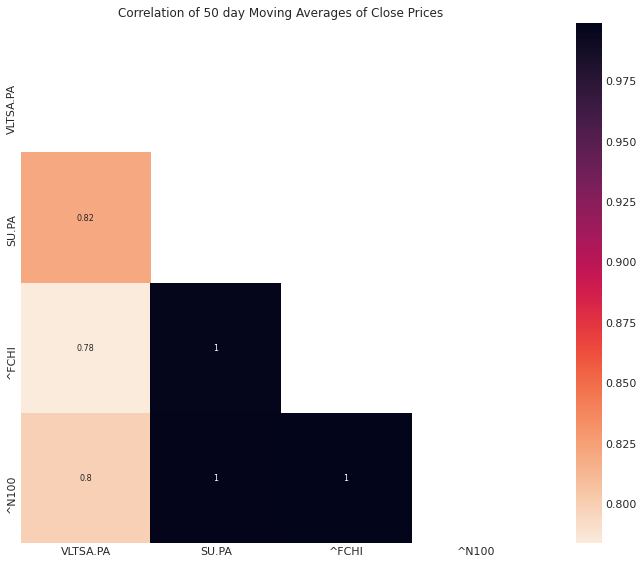

In [172]:
# Plot correlation of returns between group of tickers
plot_corr_daily_returns(tickers, start_date, end_date, ma_days)

### Trade Recommendations

In [173]:
# Create trade recommendations

# Create moving averages
rolling_20 = np.round(df_raw_prices.rolling(window=20, center=False).mean(), 2)
rolling_50 = np.round(df_raw_prices.rolling(window=50, center=False).mean(), 2)

# Creates df where if M.A.20 < M.A.50 then True else False
rolling_diff = pd.DataFrame(np.where(rolling_20<rolling_50, True, False), columns=df_raw_prices.columns, index=df_raw_prices.index)

# Apply following to rolling_diff dataframe:

# If yesterday == True and today == False
# Then "Sell"
# Elif yesterday == False and today == True
# Then "Buy"
# Else None
sell_opps = rolling_diff < rolling_diff.shift(periods=-1)
buy_opps = rolling_diff > rolling_diff.shift(periods=-1)

# Replace boolean values with "Buy"/"Sell" strings, then merge into single dataframe
sell_opps.replace(to_replace=True, value="Sell", inplace=True)
sell_opps.replace(to_replace=False, value=np.nan, inplace=True)
buy_opps.replace(to_replace=True, value="Buy", inplace=True)
buy_opps.replace(to_replace=False, value=np.nan, inplace=True)
all_opps = sell_opps.mask(buy_opps=="Buy", buy_opps) # Merge buy_opps with sell_opps

In [174]:
# Get all historic recommendations for a given ticker
ticker = "SU.PA"
all_opps[ticker][~all_opps[ticker].isnull()]

Date
2019-08-08    Sell
2019-09-13     Buy
2020-03-11    Sell
2020-05-05     Buy
Name: SU.PA, dtype: object

In [175]:
# Get historic price on particular date for particular ticker
# df_raw_prices[ticker]["2020-03-11"]

In [176]:
# Total counts
# buy_opps
# sell_opps
# print(f"There are {all_opps[all_opps=='Sell'].count().sum()} sell opportunities.")
# print(f"There are {all_opps[all_opps=='Buy'].count().sum()} buy opportunities.")
# all_opps.count().sum() # Counts values that are neither NA or np.nan

# all_opps[all_opps=='Sell'].loc["2021-04-26"].count().sum()
# all_opps[all_opps=='Buy'].loc["2021-04-26"].count().sum()

In [195]:
opportunity_date = "2021-04-29"

In [196]:
# Generate Buy and Sell recommendations
recommend_buy = list(all_opps.loc[opportunity_date][all_opps.loc[opportunity_date]=="Buy"].index)
recommend_sell = list(all_opps.loc[opportunity_date][all_opps.loc[opportunity_date]=="Sell"].index)

In [197]:
# Function to plot recommendations
def plot_recommendation(ticker, start_date, end_date, ax):
    
    base = df_raw_prices.loc[start_date:end_date][ticker]
    rolling_20 = np.round(base.rolling(window=20, center=False).mean(), 2)
    rolling_50 = np.round(base.rolling(window=50, center=False).mean(), 2)
    rolling_200 = np.round(base.rolling(window=200, center=False).mean(), 2)

    ax = ax
    ax.plot(base, label="Close", linewidth=4, alpha=.2)
    ax.plot(rolling_20, label="20d M.A.", linestyle="dashed", linewidth=2)
    ax.plot(rolling_50, label="50d M.A.", linestyle="dashed", linewidth=2)
    ax.plot(rolling_200, label="200d M.A.", linestyle="dashed", linewidth=2)
    ax.set_ylabel("Close Price")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.set_title(f"{ticker}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()

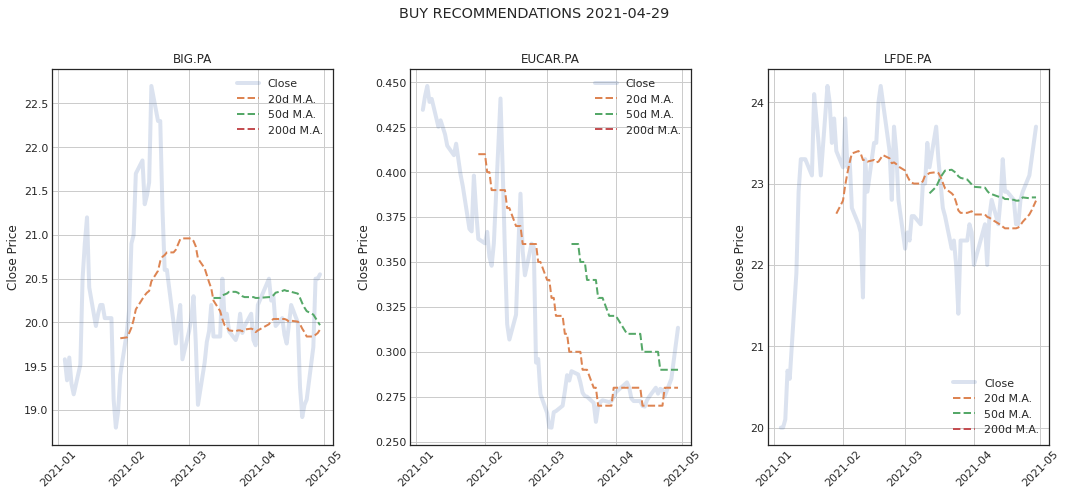

In [198]:
# Plot Buy recommendations
if math.ceil(len(recommend_buy)/3) == 1:
    height = (math.ceil(len(recommend_buy))/3*4)+3
else:
    height = (math.ceil(len(recommend_buy))/3*4)

fig = plt.figure(figsize=(15, height))
for buy in recommend_buy:
    n = recommend_buy.index(buy)+1
#     print(n)
    ax = fig.add_subplot(math.ceil(len(recommend_buy)/3), 3, n)
    plot_recommendation(buy, "2021-01-01", opportunity_date, ax=ax)
plt.suptitle(f"BUY RECOMMENDATIONS {opportunity_date}\n")
plt.tight_layout()

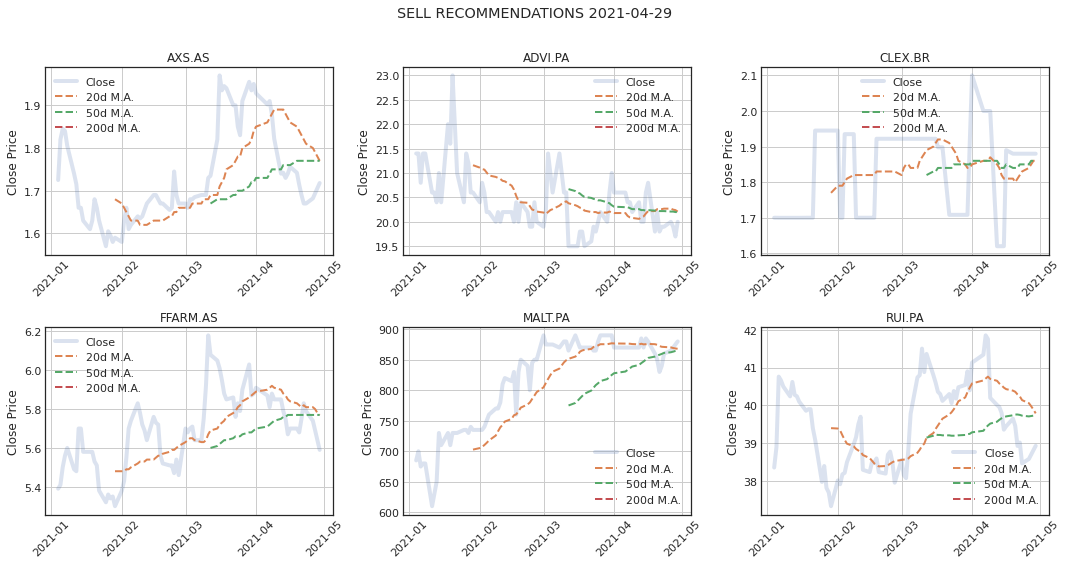

In [199]:
# Plot Sell recommendations
if math.ceil(len(recommend_sell)/3) == 1:
    height = (math.ceil(len(recommend_sell))/3*4)+3
else:
    height = (math.ceil(len(recommend_sell))/3*4)

fig = plt.figure(figsize=(15,height))
for sell in recommend_sell:
    n = recommend_sell.index(sell)+1
#     print(n)
    ax = fig.add_subplot(math.ceil(len(recommend_sell)/3), 3, n)
    plot_recommendation(sell, "2021-01-01", opportunity_date, ax=ax)
plt.suptitle(f"SELL RECOMMENDATIONS {opportunity_date}\n")
plt.tight_layout()

### Back-test trading strategy

In [182]:
# Function to run Back-testing

def run_backtest(start_date, end_date):

    # Generate Buy trades
    index = all_opps.index
    buy_trades = {}
    for ticker in all_opps.columns:
        condition = all_opps[ticker] == "Buy"
        buy_indices = index[condition]
        buy_indices_list = buy_indices.tolist()
        buy_ind_dates = [str(ts.year) + "-" + str(ts.month) + "-" + str(ts.day) for ts in buy_indices_list]
        df_raw_prices.loc[buy_ind_dates][ticker]
        buy_prices = list(df_raw_prices.loc[buy_ind_dates][ticker].values)
        buy_trades[ticker] = list(zip(buy_ind_dates, buy_prices))

    # Generate Sell trades
    index = all_opps.index
    sell_trades = {}
    for ticker in all_opps.columns:
        condition = all_opps[ticker] == "Sell"
        sell_indices = index[condition]
        sell_indices_list = sell_indices.tolist()
        sell_ind_dates = [str(ts.year) + "-" + str(ts.month) + "-" + str(ts.day) for ts in sell_indices_list]
        df_raw_prices.loc[sell_ind_dates][ticker]
        sell_prices = list(df_raw_prices.loc[sell_ind_dates][ticker].values)
        sell_trades[ticker] = list(zip(sell_ind_dates, sell_prices))

    # Apply strategy and calculate p&l per ticker:

    profits_losses = []

    for ticker in df_raw_prices.columns.to_list()[:-2]: # -2 to exclude the indices CAC40 and Euronext
    # for ticker in df_raw_prices.columns.to_list()[650:655]: # for testing use the first (tickers)
    #     print("=" * 72)
    #     print(ticker)
        buy_dates = [datetime.strptime(trade[0], "%Y-%m-%d").date() for trade in buy_trades[ticker]]
        sell_dates = [datetime.strptime(trade[0], "%Y-%m-%d").date() for trade in sell_trades[ticker]]
        all_dates = buy_dates + sell_dates
        
#         print(type(all_dates[0]))
        
        direction = [-1 for date in buy_dates] + [1 for date in sell_dates]
        buy_close = [trade[1] for trade in buy_trades[ticker]]
        sell_close = [trade[1] for trade in sell_trades[ticker]]
        all_close = buy_close + sell_close
        df_executions = pd.DataFrame({
            "Direction": direction,
            "Close": all_close,
        }, index=all_dates)
        df_executions.sort_index(inplace=True)
        df_executions["Cashflow"] = df_executions["Direction"] * df_executions["Close"]
        
        # Keep executions only within the prescribed date range we are running the backtest for:
        s = pd.to_datetime(start_date).date()
        e = pd.to_datetime(end_date).date()
        df_executions = df_executions[s:e]
        
    #     try:
    #         print("First", df_executions.iloc[0]["Direction"])
    #     except:
    #         pass
    #     try:
    #         print("Last,", df_executions.iloc[len(df_executions)-1]["Direction"])
    #     except:
    #         pass

        # Execution Rules
        # ---------------
        # Always start with a Buy and always end with a Sell. Avoid short selling and unrealised p&l.

        try:
            # Drop first row if its a Sell
            if df_executions.iloc[0]["Direction"] == 1:
                df_executions.drop(df_executions.index[0], inplace=True, axis=0)
        except:
            pass

        try:
            # Drop last row if its a Buy
            if df_executions.iloc[len(df_executions)-1]["Direction"] == -1:
                df_executions.drop(df_executions.index[len(df_executions)-1], inplace=True, axis=0)
        except:
            pass

    #     print(df_executions)
        ticker_pnl = df_executions["Cashflow"].sum()
        profits_losses.append(ticker_pnl)
    
    df_Backtest_Results = pd.DataFrame({
        "Back-test PnL":profits_losses,
    }, index=df_raw_prices.columns[:-2])
    
    return df_Backtest_Results, df_executions
    

In [183]:
# Generate backtest results
start_date = "2019-01-01"
end_date = "2021-12-31"

df_Backtest_Results, df_executions = run_backtest(start_date, end_date)

In [184]:
# df_executions

In [185]:
df_Backtest_Results.sort_values(by="Back-test PnL", ascending=False)

,Back-test PnL
MONC.PA,1039.700195
ADYEN.AS,845.000000
BGHS.AS,305.000000
MALT.PA,289.488281
FLOB.BR,236.480014
...,...
EPCP.PA,-139.800049
CBDG.PA,-147.142578
RBT.PA,-151.287659
AM.PA,-453.000000


In [186]:
df_Backtest_Results.describe()

,Back-test PnL
count,704.000000
mean,4.386320
std,64.245317
min,-487.291504
25%,-1.234172
50%,0.059104
75%,3.119948
max,1039.700195


In [187]:
df_Backtest_Results.sum()

Back-test PnL    3087.969583
dtype: float64

array([[<AxesSubplot:title={'center':'Back-test PnL'}>]], dtype=object)

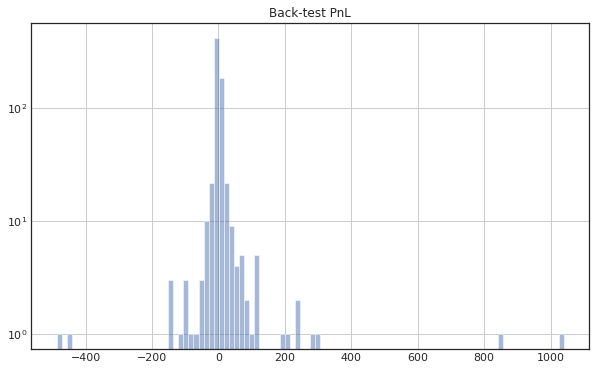

In [188]:
df_Backtest_Results.hist(bins=100, log=True, figsize=(10, 6), alpha=.5)

In [189]:
df_Backtest_Results.loc["VLTSA.PA"]

Back-test PnL    11.289999
Name: VLTSA.PA, dtype: float64

### Test widgets

#### Test 1: single widgets

In [ ]:
def print_value(myvalue):
    print(f"The current value is: {myvalue}")

In [ ]:
widgets.interact(print_value, myvalue=[1, 2, 3, 4, 5]) # use list to create dropdown

In [ ]:
widgets.interact(print_value, myvalue=(0, 10, 1)) # use tuple to create number slider

In [ ]:
widgets.interact(print_value, myvalue=(0, 10, .5)) # for decimal values

In [ ]:
widgets.interact(print_value, myvalue=True) # for boolean

In [ ]:
# Multiselect dropdown. Use shift or ctrl to select multiple values
w = widgets.SelectMultiple(
    options=['Apples', 'Oranges', 'Pears'],
    value=['Oranges'],
    #rows=10,
    description='Fruits',
    disabled=False
)
w

In [ ]:
print(w.value)

#### Test 2: multiple widgets

In [ ]:
def three_variables(x, y, z):
    return (x, y, z)

In [ ]:
_ = widgets.interact(
    three_variables,
    x=["Blue", "Green", "Black"],
    y=(1, 5, 1),
    z=True,
)

#### Fixed variables

In [ ]:
_ = widgets.interact(
    three_variables,
    x=["Blue", "Green", "Black"],
    y=(1, 5, 1),
    z=widgets.fixed("I am fixed"),
)

   #### Create widgets with decorators

In [ ]:
@widgets.interact(x=(0, 10, 1), y=["a", "b", "c"])
def print_slider_val(x, y):
    print(f"Slider says: {x}. Dropdown says: {y}")

#### Create one of my charts

In [ ]:
ticker_list = list(df_raw_prices.columns)
ticker_list.sort()
@widgets.interact(
    ticker=ticker_list,
    start_date=widgets.Text(value="2020-01-01", description="start date", continuous_update=False),
    end_date=widgets.Text(value="2020-12-31", description="end date", continuous_update=False),
)
def plot_ticker(ticker, start_date, end_date):
    df_raw_prices.loc[start_date:end_date][ticker].plot()
    plt.title(ticker)